In [72]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood, LeaveOneOutPseudoLikelihood
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from gpytorch.priors import GammaPrior, LogNormalPrior
import gpytorch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement, qNoisyExpectedHypervolumeImprovement, qLogNoisyExpectedHypervolumeImprovement
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.box_decompositions import NondominatedPartitioning
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list

from botorch.utils.transforms import unnormalize
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

ImportError: cannot import name 'qLogNoisyExpectedHypervolumeImprovement' from 'botorch.acquisition.multi_objective.monte_carlo' (C:\Users\eschw\anaconda3\envs\mobo-env\lib\site-packages\botorch\acquisition\multi_objective\monte_carlo.py)

In [73]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))


2.4.0
True
12.4
NVIDIA GeForce GTX 1080 with Max-Q Design


In [74]:
def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value
    
def get_closest_array(suggested_x, var_list):
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [75]:
def make_linspace(start, stop, step):
    num_points = int(round((stop - start) / step)) + 1
    return np.round(np.linspace(start, stop, num_points), 4)  # round for cleaner floats

speed_inorg_var   = make_linspace(0.25, 1.00, 0.01)  # m/min
speed_org_var     = make_linspace(0.25, 1.00, 0.01)  # m/min
inkFL_inorg_var   = make_linspace(80, 240, 1)       # uL/min
inkFL_org_var     = make_linspace(100, 280, 1)      # uL/min
conc_inorg_var    = make_linspace(0.8, 1.4, 0.05)     # M
conc_org_var      = make_linspace(0.4, 1.2, 0.05)     # M
humidity_var      = make_linspace(2, 37, 1)        # g/m^3
temp_var          = make_linspace(20, 50, 1)        # °C

# Tracking unique values
speed_inorg_num   = len(speed_inorg_var)
speed_org_num     = len(speed_org_var)
inkFL_inorg_num   = len(inkFL_inorg_var)
inkFL_org_num     = len(inkFL_org_var)
conc_inorg_num    = len(conc_inorg_var)
conc_org_num      = len(conc_org_var)
humidity_num      = len(humidity_var)
temp_num          = len(temp_var)

# Pack into var_array for downstream normalization
var_array = [speed_inorg_var, speed_org_var, 
             inkFL_inorg_var, inkFL_org_var,
             conc_inorg_var, conc_org_var,
             humidity_var, temp_var]

x_labels = ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 
            'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]',
            'Conc. (Inorg) [M]', 'Conc. (Org) [M]',
            'AH [g/m^3]', 'Temp [C]']

In [76]:
# parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
#                                   ContinuousParameter('x2', 0, 1),
#                                   ContinuousParameter('x3', 0, 1),
#                                   ContinuousParameter('x4', 0, 1),
#                                   ContinuousParameter('x5', 0, 1),
#                                   ContinuousParameter('x6', 0, 1),
#                                   ContinuousParameter('x7', 0, 1),
#                                   ContinuousParameter('x8', 0, 1),
#                                  ])

## why is the parameter space different in the round 1 of the Joule code?

In [77]:
def check_clausius_clapeyron(ah_vals, temp_vals):
    """
    Return boolean mask for valid points satisfying Clausius-Clapeyron constraints.
    Ensures absolute humidity does not exceed saturation limit at given temperature.
    
    Parameters:
        ah_vals: array-like, absolute humidity [g/m³]
        temp_vals: array-like, temperature [°C]
        
    Returns:
        valid_mask: boolean array, True if AH is within saturation limit
    """
    valid_mask = []
    for AH, T in zip(ah_vals, temp_vals):
        # Saturation vapor pressure (kPa)
        es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
        # Max absolute humidity (g/m³)
        AH_max = 216.7 * es / (T + 273.15)
        valid_mask.append(AH <= AH_max)
    return np.array(valid_mask)

In [154]:
#Load your real LHS experimental results (replace with real path)
dataset_final = pd.read_csv(r'C:\Users\eschw\Downloads\R0 Summary for MOBO R1 conditions.csv')
#dataset_np = dataset_final.to_numpy()
#print(dataset_np)

#Extract input features (first 8 columns assumed to be process parameters) ===
X = dataset_final.iloc[:, 0:8].values  # shape: (8, 8)

#Extract targets
y = dataset_final[['PCE', 'Stability', 'Repeatability']].values  # shape: (8, 3)
#print(y)

#Standardize input and output
X_scaled = x_normalizer(X, var_array)
# Y_scaled = StandardScaler().fit_transform(y) ## is this the right way to normalize this? do i need to normalize this?
Y_max = np.max(y, axis=0)
Y_min = np.min(y, axis=0)
Y_scaled = (y - Y_min) / (Y_max - Y_min)
Y_scaled[:, 2] = 1 - Y_scaled[:, 2]
#print(Y_scaled)

#Convert to torch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_X = torch.tensor(X_scaled, dtype=torch.float64, device=device)
#print(train_X)
train_Y = torch.tensor(Y_scaled, dtype=torch.float64, device=device)
print(train_Y)
print(train_X)

#Set seeds for reproducibility
np.random.seed(20)
torch.manual_seed(20)

tensor([[0.9057, 0.0000, 0.0947],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.6506, 0.2377, 0.7895],
        [0.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.0000]], device='cuda:0', dtype=torch.float64)
tensor([[0.0667, 0.0667, 0.0156, 0.1111, 1.0000, 0.0000, 0.0000, 0.1000],
        [0.4400, 0.0667, 0.6875, 0.1889, 0.0833, 0.4375, 0.0286, 0.1567],
        [0.9333, 0.4400, 0.5625, 0.8111, 0.1667, 0.5625, 0.4857, 0.8000],
        [0.5600, 0.9333, 0.4375, 0.4389, 0.4167, 0.9375, 0.1143, 0.3933],
        [0.6933, 0.1867, 0.3125, 0.9389, 0.5833, 0.3125, 0.1143, 0.2833],
        [0.1867, 0.5600, 0.9375, 0.5611, 0.6667, 0.1875, 0.3714, 0.7200],
        [0.0667, 0.8133, 0.0625, 0.6889, 0.8333, 0.6875, 0.4857, 0.7200],
        [0.8133, 0.3067, 0.8125, 0.0611, 0.9167, 0.8125, 0.4000, 0.5433]],
       device='cuda:0', dtype=torch.float64)


In [129]:
dataset_final

,Speed (Inorg) [m/min],Speed (Org) [m/min],Pump rate (Inorg) [uL/min],Pump rate (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],AH (Org) [g/m^3],Temp (Org) [C],PCE,Stability,Repeatability
0,0.30,0.30,82.5,120,1.40,0.40,2,23.0,14.88,0.00,0.86
1,0.58,0.30,190.0,134,0.85,0.75,3,24.7,0.00,0.00,0.00
2,0.95,0.58,170.0,246,0.90,0.85,19,44.0,0.00,0.00,0.00
3,0.67,0.95,150.0,179,1.05,1.15,6,31.8,0.00,0.00,0.00
4,0.77,0.39,130.0,269,1.15,0.65,6,28.5,0.00,0.00,0.00
5,0.39,0.67,230.0,201,1.20,0.55,15,41.6,10.69,1.35,0.20
6,0.30,0.86,90.0,224,1.30,0.95,19,41.6,0.00,0.00,0.00
7,0.86,0.48,210.0,111,1.35,1.05,16,36.3,16.43,5.68,0.95


In [130]:
def fit_gp_models(X, Y, kernel_fn=None, noise_prior=None):
    """
    Fits a list of GP models for each output dimension.
    Returns a ModelListGP.
    
    Args:
        X: torch tensor of shape (N, D)
        Y: torch tensor of shape (N, M)
        kernel_fn: function taking D and returning a GPyTorch kernel
        noise_prior: artificial noise to kernel

    Returns:
        model: ModelListGP with one GP per output
    """
    models = []
    for j in range(Y.shape[1]):
        covar_module = ScaleKernel(kernel_fn(X.shape[1])) if kernel_fn else RBFKernel(ard_num_dims = X.shape[1])
        likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior) if noise_prior else gpytorch.likelihoods.GaussianLikelihood()
        gp = SingleTaskGP(X, Y[:, j:j+1], covar_module=covar_module, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        #mll = LeaveOneOutPseudoLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        models.append(gp)
    return ModelListGP(*models)

# for i, gp in enumerate(gp_models):
#     ls = gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
#     print(f"Objective {i+1} lengthscales: {np.round(ls, 3)}")


In [131]:
matern_options = {
    "Matern_0.5": lambda d: MaternKernel(nu=0.5, ard_num_dims=d),
    "Matern_1.5": lambda d: MaternKernel(nu=1.5, ard_num_dims=d),
    "Matern_2.5": lambda d: MaternKernel(nu=2.5, ard_num_dims=d),
}

noise_options = {
    "None": None,
    "Gamma(1.1, 0.05)": GammaPrior(1.1, 0.05).to(device),
    "LogNormal(-4, 0.1)": LogNormalPrior(-4.0, 0.5).to(device),
}

In [132]:
# Grid search with LOO-CV
results = []
best_rmse = [np.inf] * train_Y.shape[1]
best_models = [None] * train_Y.shape[1]

for kernel_name, kernel_fn in matern_options.items():
    for noise_name, noise_prior in noise_options.items():
        preds_all = [[] for _ in range(train_Y.shape[1])]
        actuals_all = [[] for _ in range(train_Y.shape[1])]

        for i in range(train_X.shape[0]):
            X_cv = torch.cat([train_X[:i], train_X[i+1:]])
            Y_cv = torch.cat([train_Y[:i], train_Y[i+1:]])
            model_cv = fit_gp_models(X_cv, Y_cv, kernel_fn, noise_prior)

            for j, gp in enumerate(model_cv.models):
                pred = gp.posterior(train_X[i:i+1]).mean.item()
                preds_all[j].append(pred)
                actuals_all[j].append(train_Y[i, j].item())

        for j in range(train_Y.shape[1]):
            r2 = r2_score(actuals_all[j], preds_all[j])
            rmse = mean_squared_error(actuals_all[j], preds_all[j], squared=False)
            
            # Save best model for this objective
            if rmse < best_rmse[j]:
                best_rmse[j] = rmse
                model_j = fit_gp_models(train_X, train_Y, kernel_fn, noise_prior).models[j]
                best_models[j] = model_j


            results.append({
                "Kernel": kernel_name,
                "NoisePrior": noise_name,
                "Objective": ["PCE", "Stability", "Repeatability"][j],
                "R2": round(r2, 3),
                "RMSE": round(rmse, 3)
            })
            
model = ModelListGP(*best_models)

# Show results in a DataFrame
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

    Kernel         NoisePrior     Objective     R2  RMSE
Matern_0.5               None           PCE -1.532 0.672
Matern_0.5               None     Stability -0.246 0.367
Matern_0.5               None Repeatability -1.025 0.575
Matern_0.5   Gamma(1.1, 0.05)           PCE -1.441 0.660
Matern_0.5   Gamma(1.1, 0.05)     Stability -0.063 0.339
Matern_0.5   Gamma(1.1, 0.05) Repeatability -0.974 0.567
Matern_0.5 LogNormal(-4, 0.1)           PCE -1.674 0.691
Matern_0.5 LogNormal(-4, 0.1)     Stability -0.238 0.366
Matern_0.5 LogNormal(-4, 0.1) Repeatability -1.009 0.572
Matern_1.5               None           PCE -1.473 0.664
Matern_1.5               None     Stability -0.247 0.367
Matern_1.5               None Repeatability -1.375 0.622
Matern_1.5   Gamma(1.1, 0.05)           PCE -1.472 0.664
Matern_1.5   Gamma(1.1, 0.05)     Stability -0.347 0.382
Matern_1.5   Gamma(1.1, 0.05) Repeatability -1.379 0.623
Matern_1.5 LogNormal(-4, 0.1)           PCE -1.600 0.681
Matern_1.5 LogNormal(-4, 0.1)  

[[ 8.81750162e-01  1.68933651e-02  8.67137507e-02]
 [ 9.09196457e-03  1.56690456e-02  9.96708348e-01]
 [ 5.12375491e-04  1.05653783e-02  9.99984523e-01]
 [ 1.95982376e-02  1.46428673e-02  9.85204061e-01]
 [-4.48693139e-03  1.68445666e-02  1.00061802e+00]
 [ 6.28982832e-01  2.64144661e-01  8.09152369e-01]
 [ 2.78691662e-02  1.26756171e-02  9.81969048e-01]
 [ 9.92981047e-01  8.86240355e-01  2.38606894e-02]]


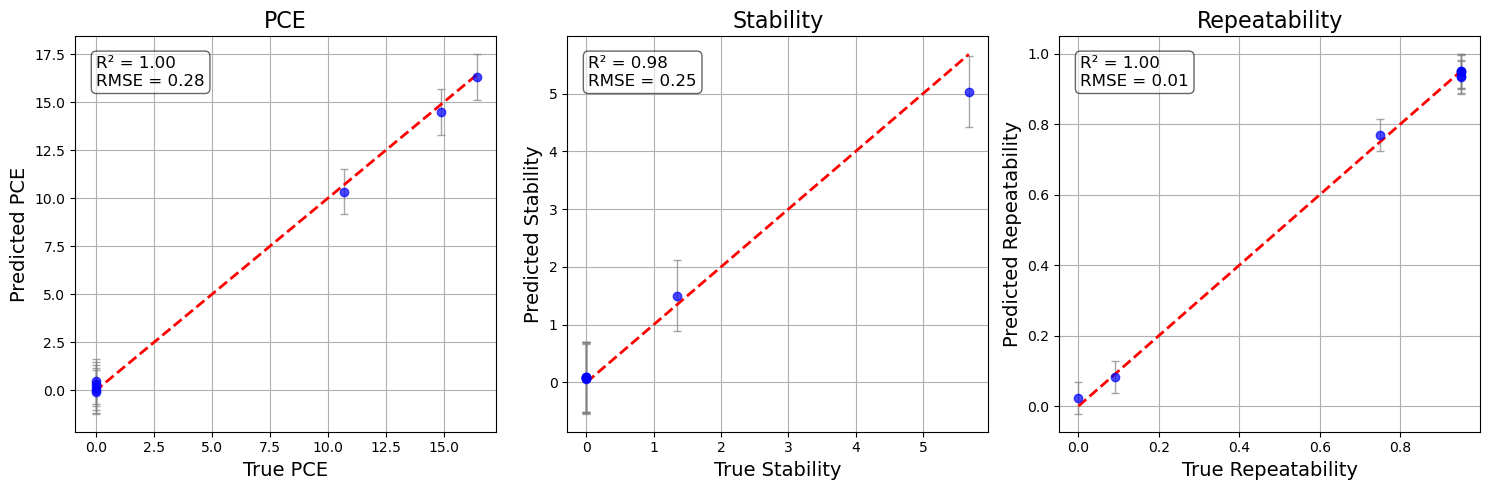

--- Model 1 (PCE) ---
Kernel: MaternKernel
Matern ν: 2.5
Noise prior: GammaPrior

--- Model 2 (Stability) ---
Kernel: MaternKernel
Matern ν: 0.5
Noise prior: GammaPrior

--- Model 3 (Repeatability) ---
Kernel: MaternKernel
Matern ν: 1.5
Noise prior: LogNormalPrior



In [133]:
# Evaluate posterior predictions on training data

posterior = model.posterior(train_X)
pred_std = torch.sqrt(posterior.variance).detach().cpu().numpy()
pred_mean = posterior.mean.detach().cpu().numpy()
print(pred_mean)
#pred_mean = torch.cat([p.mean for p in posterior.distributions], dim=-1)
true_Y = train_Y.detach().cpu().numpy()  # already scaled

# Reverse scaling
pred_mean_unnorm = pred_mean * (Y_max - Y_min) + Y_min
pred_std_unnorm = pred_std * (Y_max - Y_min)
true_mean_unnorm = true_Y * (Y_max - Y_min) + Y_min

# # Flip repeatability back
# pred_mean_unnorm[:, 2] *= -1
# true_mean_unnorm[:, 2] *= -1


labels = ['PCE', 'Stability', 'Repeatability']
num_obj = train_Y.shape[1]

fig, axes = plt.subplots(1, num_obj, figsize=(5 * num_obj, 5))

for i in range(num_obj):
    ax = axes[i]

    # Compute metrics
    r2 = r2_score(true_mean_unnorm[:, i], pred_mean_unnorm[:, i])
    rmse = mean_squared_error(true_mean_unnorm[:, i], pred_mean_unnorm[:, i], squared=False)

    # Parity scatter with uncertainty bars
    ax.errorbar(
        true_mean_unnorm[:, i], pred_mean_unnorm[:, i],
        yerr=pred_std_unnorm[:, i],
        fmt='o', color='blue', ecolor='gray', elinewidth=1, capsize=3,
        alpha=0.7
    )

    # Parity line
    min_val = min(true_mean_unnorm[:, i].min(), pred_mean_unnorm[:, i].min())
    max_val = max(true_mean_unnorm[:, i].max(), pred_mean_unnorm[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    # Labels and metrics
    ax.set_xlabel('True ' + labels[i], fontsize=14)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=14)
    ax.set_title(f'{labels[i]}', fontsize=16)
    ax.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}', transform=ax.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor='white', alpha=0.6))

    ax.grid(True)

plt.tight_layout()
plt.show()

for i, gp in enumerate(model.models):
    print(f"--- Model {i+1} ({['PCE', 'Stability', 'Repeatability'][i]}) ---")
    # Kernel type
    kernel = gp.covar_module.base_kernel
    print("Kernel:", type(kernel).__name__)

    # Check Matern ν if it's a Matern kernel
    if hasattr(kernel, "nu"):
        print("Matern ν:", kernel.nu)

    # Noise prior info
    noise_prior = gp.likelihood.noise_covar.raw_noise_constraint.initial_value
    prior_type = type(gp.likelihood.noise_covar.noise_prior).__name__ if gp.likelihood.noise_covar.noise_prior else "None"
    print("Noise prior:", prior_type)
    
    # print("Lengthscales:", gp.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten())
    # print("Outputscale:", gp.covar_module.outputscale.item())
    # print("Noise:", gp.likelihood.noise.item())
    print()


In [ ]:
# --- Fit generic GP model with default settings ---
model_generic = fit_gp_models(train_X, train_Y)

# --- Posterior prediction ---
posterior_generic = model_generic.posterior(train_X)
pred_std_gen = torch.sqrt(posterior_generic.variance).detach().cpu().numpy()
pred_mean_gen = posterior_generic.mean.detach().cpu().numpy()
true_Y = train_Y.detach().cpu().numpy()

# --- Reverse scaling ---
pred_mean_unnorm_gen = pred_mean_gen * (Y_max - Y_min) + Y_min
pred_std_unnorm_gen = pred_std_gen * (Y_max - Y_min)
true_mean_unnorm = true_Y * (Y_max - Y_min) + Y_min

# --- Flip repeatability back ---
# pred_mean_unnorm_gen[:, 2] *= -1
# true_mean_unnorm[:, 2] *= -1

labels = ['PCE', 'Stability', 'Repeatability']
num_obj = train_Y.shape[1]

# --- Plot parity plots ---
fig, axes = plt.subplots(1, num_obj, figsize=(5 * num_obj, 5))
for i in range(num_obj):
    ax = axes[i]
    r2 = r2_score(true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i])
    rmse = mean_squared_error(true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i], squared=False)

    ax.errorbar(
        true_mean_unnorm[:, i], pred_mean_unnorm_gen[:, i],
        yerr=pred_std_unnorm_gen[:, i],
        fmt='o', color='blue', ecolor='gray', elinewidth=1, capsize=3, alpha=0.7
    )

    min_val = min(true_mean_unnorm[:, i].min(), pred_mean_unnorm_gen[:, i].min())
    max_val = max(true_mean_unnorm[:, i].max(), pred_mean_unnorm_gen[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    ax.set_xlabel('True ' + labels[i], fontsize=14)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=14)
    ax.set_title(f'{labels[i]}', fontsize=16)
    ax.text(0.05, 0.95, f'R² = {r2:.2f}\nRMSE = {rmse:.2f}',
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor='white', alpha=0.6))
    ax.grid(True)

plt.tight_layout()
plt.show()

In [135]:
pareto_mask = is_non_dominated(train_Y)
pareto_Y = train_Y[pareto_mask]

ref_point = torch.tensor([-0.1, -0.1, -0.1], device=device) #
                        
hv = Hypervolume(ref_point=ref_point)
volume = hv.compute(pareto_Y)
print(train_Y)
print("Ref point:", ref_point)
print("Hypervolume:", volume)
print("Pareto size:", pareto_Y.shape[0])

tensor([[0.9057, 0.0000, 0.0947],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.6506, 0.2377, 0.7895],
        [0.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.0000]], device='cuda:0', dtype=torch.float64)
Ref point: tensor([-0.1000, -0.1000, -0.1000], device='cuda:0')
Hypervolume: 0.32563138008117676
Pareto size: 4


In [ ]:
pareto_Y[:, 2] *= -1
pareto_Y_np = pareto_Y.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np[:, 0], pareto_Y_np[:, 1], pareto_Y_np[:, 2],
           c='green', s=50, label='Pareto Front', depthshade=True)

# Optionally, plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Label axes
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()

In [192]:
acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point,
    X_baseline=train_X,
    sampler=SobolQMCNormalSampler(sample_shape=torch.Size([64])),
    #eta=0.05,
    prune_baseline=True,
    alpha=0.0,
)

C:\Users\eschw\anaconda3\envs\mobo-env\lib\site-packages\botorch\acquisition\multi_objective\monte_carlo.py:321: NumericsWarning: qNoisyExpectedHypervolumeImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 qNoisyExpectedHypervolumeImprovement 	 --> 	 qLogNoisyExpectedHypervolumeImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


In [112]:
acq_func_gen = qNoisyExpectedHypervolumeImprovement(
    model=model_generic,
    ref_point=ref_point,
    X_baseline=train_X,
    sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
    #eta=0.05,
    prune_baseline=False,
    alpha=0.0,
)

NameError: name 'model_generic' is not defined

In [193]:
NUM_RESTARTS = 20
RAW_SAMPLES = 512
BATCH_SIZE = 4
MAX_ATTEMPTS = 1

bounds = torch.tensor([[0.0] * 8, [1.0] * 8], device=device)

valid_candidates = None
valid_candidates_gen=None
attempts = 0

# while attempts < MAX_ATTEMPTS:
#     attempts += 1

    # Optimize acquisition function in normalized space
candidates, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,
    options={"batch_limit": 4, "maxiter": 200},
    sequential=True,
)

    # Optimize acquisition function in normalized space for generic regressor
    # candidates_gen, _ = optimize_acqf(
    #     acq_function=acq_func_gen,
    #     bounds=bounds,
    #     q=BATCH_SIZE,
    #     num_restarts=NUM_RESTARTS,
    #     raw_samples=RAW_SAMPLES,
    #     options={"batch_limit": 5, "maxiter": 200},
    # )
    
    # Convert to original space and snap to valid grid
X_cont = x_denormalizer(unnormalize(candidates, bounds).cpu().numpy(), var_array)
X_snapped = get_closest_array(X_cont, var_array)

    # Convert generic to original space and snap to valid grid
    # X_cont_gen = x_denormalizer(unnormalize(candidates_gen, bounds).cpu().numpy(), var_array)
    # X_snapped_gen = get_closest_array(X_cont_gen, var_array)

    # Check Clausius-Clapeyron constraint
    # RH_vals = X_snapped[:, 6]   # RH [%]
    # Temp_vals = X_snapped[:, 7] # Temp [C]

    # RH_vals_gen = X_snapped_gen[:, 6]   # RH [%]
    # Temp_vals_gen = X_snapped_gen[:, 7] # Temp [C]
    
    # cc_mask = check_clausius_clapeyron(RH_vals, Temp_vals)
    # cc_mask_gen = check_clausius_clapeyron(RH_vals_gen, Temp_vals_gen)

    # if cc_mask.all(): #i know this isn't great logic, but we never break cc relation; just benchmarking right now
valid_candidates = X_snapped
        # # valid_candidates_gen = X_snapped_gen
        # print(f"Found valid candidates after {attempts} attempts.")
        # break

# if valid_candidates is not None: #and valid_candidates_gen is not None:
print("Final candidate batch:\n", valid_candidates)
    # print("Final generic candidate batch:\n", valid_candidates_gen)
# else:
#     print("No valid batch found after max attempts.")

Final candidate batch:
 [[  0.85   0.64 210.   231.     1.35   0.85  12.    26.  ]
 [  0.97   0.57 216.   182.     1.4    0.8   28.    37.  ]
 [  0.89   0.29 220.   275.     1.4    1.1   19.    49.  ]
 [  0.83   0.33 240.   222.     1.4    1.15  30.    43.  ]]


In [ ]:
print("Final candidate batch:\n", valid_candidates)
#print("Final generic candidate batch:\n", valid_candidates_gen)

In [194]:
# After optimizing
acq_val = acq_func(torch.tensor(x_normalizer(valid_candidates, var_array), dtype=torch.float64, device=device))
#acq_val_gen = acq_func_gen(torch.tensor(x_normalizer(valid_candidates_gen, var_array), dtype=torch.float64, device=device))

# Random candidates
rand_X = torch.rand(BATCH_SIZE, train_X.shape[-1], device=device)
rand_acq_val = acq_func(rand_X)

print("Random candidate acquisition values:", rand_acq_val.detach().cpu().numpy())
print("Acquisition values of optimized suggested candidates:", acq_val.detach().cpu().numpy())
#print("Acquisition values of generic suggested candidates:", acq_val_gen.detach().cpu().numpy())

Random candidate acquisition values: [0.00288875]
Acquisition values of optimized suggested candidates: [0.01465591]


In [195]:
X_new_scaled = torch.tensor(x_normalizer(valid_candidates, var_array), dtype=torch.float64, device=device)
#X_new_scaled_gen = torch.tensor(x_normalizer(valid_candidates_gen, var_array), dtype=torch.float64, device=device)

posterior_new = model.posterior(X_new_scaled)
mean_new = posterior_new.mean.detach().cpu().numpy()
std_new = posterior_new.variance.sqrt().detach().cpu().numpy()
mean_new_unnorm = mean_new * (Y_max - Y_min) + Y_min
std_new_unnorm = std_new * (Y_max - Y_min)
# mean_new_unnorm[:, 2] *= -1
#std_new_unnorm[:, 2] *= -1

# posterior_new_gen = model_generic.posterior(X_new_scaled_gen)
# mean_new_gen = posterior_new_gen.mean.detach().cpu().numpy()
# std_new_gen = posterior_new_gen.variance.sqrt().detach().cpu().numpy()
# mean_new_unnorm_gen = mean_new_gen * (Y_max - Y_min) + Y_min
# std_new_unnorm_gen = std_new_gen * (Y_max - Y_min)
# mean_new_unnorm_gen[:, 2] *= -1

columns = ['PCE', 'Stability', 'Repeatability']
results_df = pd.DataFrame(mean_new_unnorm, columns=[f'{col}_mean' for col in columns])
for i, col in enumerate(columns):
    results_df[f'{col}_std'] = std_new_unnorm[:, i]

# results_df_gen = pd.DataFrame(mean_new_unnorm_gen, columns=[f'{col}_mean' for col in columns])
# for i, col in enumerate(columns):
#     results_df_gen[f'{col}_std'] = std_new_unnorm_gen[:, i]

# Add parameter values too
param_df = pd.DataFrame(valid_candidates, columns=x_labels)
full_results = pd.concat([param_df, results_df], axis=1)
#print(full_results.values.tolist())

# param_df_gen = pd.DataFrame(valid_candidates_gen, columns=x_labels)
# full_results_gen = pd.concat([param_df_gen, results_df_gen], axis=1)

In [196]:
full_results

,Speed (Inorg) [m/min],Speed (Org) [m/min],inkFL (Inorg) [uL/min],inkFL (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],AH [g/m^3],Temp [C],PCE_mean,Stability_mean,Repeatability_mean,PCE_std,Stability_std,Repeatability_std
0,0.85,0.64,210.0,231.0,1.35,0.85,12.0,26.0,9.968040,5.030419,0.956891,3.455028,0.621520,0.098370
1,0.97,0.57,216.0,182.0,1.40,0.80,28.0,37.0,13.954156,3.940680,0.582291,3.329807,1.290705,0.187314
2,0.89,0.29,220.0,275.0,1.40,1.10,19.0,49.0,8.874608,3.770521,0.957070,5.177092,1.344709,0.241858
3,0.83,0.33,240.0,222.0,1.40,1.15,30.0,43.0,12.646785,2.769617,0.890411,4.161192,1.579061,0.149726


In [65]:
# full_results_gen
print(mean_new)

[[ 0.54852876  0.88516943  0.04352899]
 [-0.02403182  0.12423929 -0.04972143]
 [-0.11500688  0.12856106  0.06174395]
 [ 0.76973734  0.4876084  -0.06272536]
 [ 0.81066491  0.86717505 -0.42012853]]


In [145]:
def compute_diversity_score(X: np.ndarray) -> float:
    """
    Computes the average pairwise Euclidean distance between rows in X.
    A higher value indicates greater diversity among candidate points.
    
    Args:
        X (np.ndarray): 2D array of shape (n_points, n_features)

    Returns:
        float: average pairwise distance
    """
    if len(X) < 2:
        return 0.0  # Not enough points to compute diversity
    distances = pdist(X, metric='euclidean')  # All pairwise distances
    return distances.mean()


In [197]:
diversity = compute_diversity_score(X_new_scaled.cpu().numpy())
#diversity_gen = compute_diversity_score(X_new_scaled_gen.cpu().numpy())
print(f"Diversity score of batch: {diversity:.4f}")
#print(f"Diversity score of generic batch: {diversity_gen:.4f}")

Diversity score of batch: 0.7861


0.7712543606758118
0.5372302532196045
0.5414943099021912
0.5301148891448975


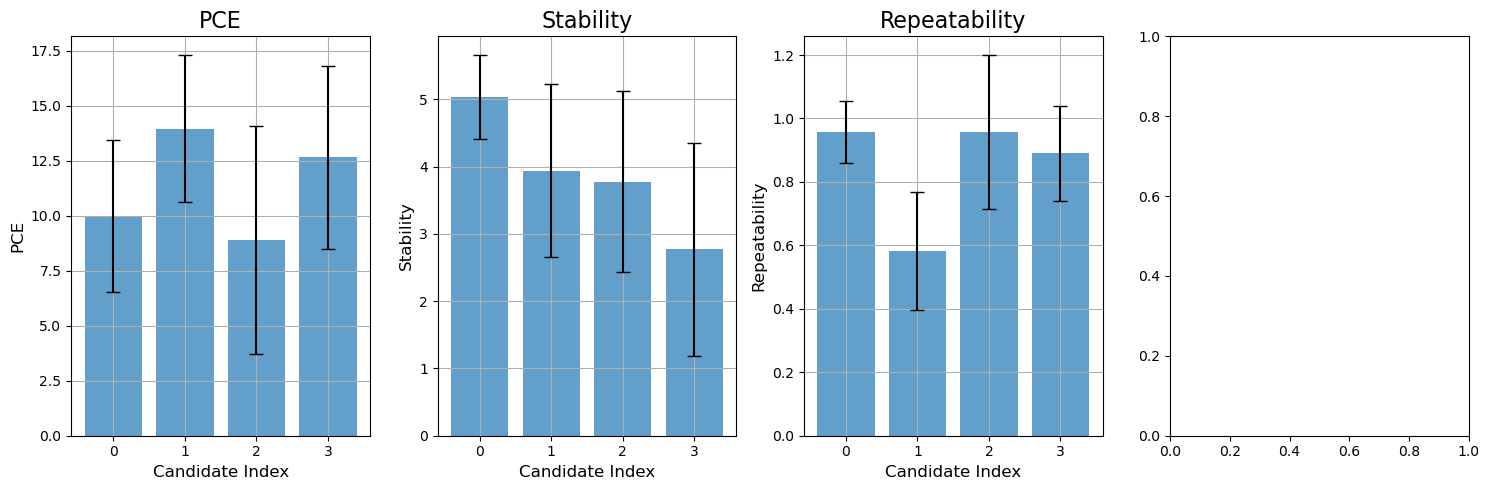

In [198]:
labels = ['PCE', 'Stability', 'Repeatability']
num_candidates = mean_new_unnorm.shape[0]
x = np.arange(num_candidates)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
hv_values = []
# Define reference point and compute Pareto front
for i in range(num_candidates):
    pareto_mask_cand = is_non_dominated(torch.tensor(mean_new[i:i+1], device=device, dtype=torch.float64))
    pareto_Y_cand = torch.tensor(mean_new[i:i+1], device=device, dtype=torch.float64)[pareto_mask_cand]
    
    # Compute hypervolume
    hv = Hypervolume(ref_point=ref_point)
    hv_value = hv.compute(pareto_Y_cand)
    print(hv_value)

for i in range(3):
    axes[i].bar(x, mean_new_unnorm[:, i], yerr=std_new_unnorm[:, i], capsize=5, alpha=0.7)
    axes[i].set_title(labels[i], fontsize=16)
    axes[i].set_xlabel('Candidate Index', fontsize=12)
    axes[i].set_ylabel(labels[i], fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
labels = ['PCE', 'Stability', 'Repeatability']
num_candidates_gen = mean_new_unnorm_gen.shape[0]
x = np.arange(num_candidates_gen)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axes[i].bar(x, mean_new_unnorm_gen[:, i], yerr=std_new_unnorm_gen[:, i], capsize=5, alpha=0.7)
    axes[i].set_title(labels[i], fontsize=16)
    axes[i].set_xlabel('Candidate Index', fontsize=12)
    axes[i].set_ylabel(labels[i], fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Combine old and new predicted means (in normalized space)
pred_old = torch.tensor(pred_mean, dtype=torch.float64, device=device)
pred_new = torch.tensor(mean_new, dtype=torch.float64, device=device)

combined = torch.cat([pred_old, pred_new], dim=0)

# Define reference point and compute Pareto front
pareto_mask_combined = is_non_dominated(combined)
pareto_Y_combined = combined[pareto_mask_combined]

# Compute hypervolume
hv = Hypervolume(ref_point=ref_point)
hv_value = hv.compute(pareto_Y_combined)

print(f"Updated Pareto front has {pareto_Y_combined.shape[0]} points")
print(f"Hypervolume after batch: {hv_value:.4f}")
print(f"Volume Improvement of {hv_value - volume}")
print("Max predicted PCE:", combined[:, 0].max().item())
print("Max predicted Stability:", combined[:, 1].max().item())
print("Max predicted Repeatability (flipped):", combined[:, 2].max().item())



# Plot 3D Pareto front
pareto_Y_combined[:, 2] *= -1
pareto_Y_np = pareto_Y_combined.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np[:, 0], pareto_Y_np[:, 1], pareto_Y_np[:, 2],
           c='green', s=50, label='Pareto Front', depthshade=True)

# Plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Labels
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Updated Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()


In [ ]:
# Combine old and new predicted means (in normalized space)
pred_old = torch.tensor(pred_mean, dtype=torch.float64, device=device)
pred_new_gen = torch.tensor(mean_new_gen, dtype=torch.float64, device=device)

combined_gen = torch.cat([pred_old, pred_new_gen], dim=0)

# Define reference point and compute Pareto front
pareto_mask_combined_gen = is_non_dominated(combined_gen)
pareto_Y_combined_gen = combined_gen[pareto_mask_combined_gen]

# Compute hypervolume
hv = Hypervolume(ref_point=ref_point)
hv_value_gen = hv.compute(pareto_Y_combined_gen)

print(f"Updated Pareto front has {pareto_Y_combined_gen.shape[0]} points")
print(f"Hypervolume after batch: {hv_value_gen:.4f}")
print(f"Volume Improvement of {hv_value_gen - volume}")
print("Max predicted PCE:", combined_gen[:, 0].max().item())
print("Max predicted Stability:", combined_gen[:, 1].max().item())
print("Max predicted Repeatability (flipped):", combined_gen[:, 2].max().item())



# Plot 3D Pareto front
pareto_Y_combined_gen[:, 2] *= -1
pareto_Y_np_gen = pareto_Y_combined_gen.detach().cpu().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot Pareto-optimal points
ax.scatter(pareto_Y_np_gen[:, 0], pareto_Y_np_gen[:, 1], pareto_Y_np_gen[:, 2],
           c='green', s=50, label='Pareto Front Generic', depthshade=True)

# Plot the reference point
ax.scatter([ref_point[0].item()], [ref_point[1].item()], [ref_point[2].item()],
           c='red', s=60, marker='*', label='Reference Point')

# Labels
ax.set_xlabel('PCE (normalized)', fontsize=12)
ax.set_ylabel('Stability (normalized)', fontsize=12)
ax.set_zlabel('Repeatability (normalized, flipped)', fontsize=12)
ax.set_title('Updated Pareto Front (3D)', fontsize=14)

ax.legend()
ax.view_init(elev=25, azim=-45)
plt.tight_layout()
plt.show()
